In [1]:
# Standard library imports
import collections
import contextlib
import copy
import dataclasses as dc
import datetime
import enum
import functools
import gc
import hashlib
import itertools
import json
import os
import pathlib
import re
import sys
import time
from typing import Any

# Third-party imports
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import rich
import rich.console
import rich.table
import tqdm
from ast import literal_eval
from IPython.display import display, Markdown
import more_itertools as mit
import itertools as it

os.environ["OPENINSTRUCT_PARSE_LATEX_BACKEND"] = "lark" 

sys.path.append("/home/mila/g/gagnonju/marglicot/with_open-instruct/open-instruct")
from open_instruct.math_utils import (
    last_boxed_only_string,
    remove_boxed,
    get_unnormalized_answer,
    normalize_final_answer,
    is_equiv,
    hendrycks_is_equiv
)


def md_print(text):
    display(Markdown(text))


# Make Pandas display better.
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pl.Config(fmt_str_lengths=500, tbl_width_chars=10000, tbl_rows=100, tbl_cell_alignment="LEFT")



class Mode(enum.Enum):
    gsm8k = "gsm8k"
    math = "math"

class LearningType(enum.Enum):
    sft = "sft"
    rejection_sampling = "rejection_sampling"
    zero_shot = "zero_shot"
    few_shot = "few_shot"




/home/mila/g/gagnonju/marglicot/light_eval_tests/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extract the paths of all of the per epoch saves
We need all the save paths.
- We find all of the saves by looking for all of the safetensors files
- There is one save per epoch, & the save directories are .../model/checkpoint_name.safetensors, so we call .parent.parent to get the run directory.

In [2]:
SAVE_DIRECTORY = "~/scratch/rejection_sampling_saves/gsm8k_5/"
CHECKPOINT_GLOB_PATTERN = "**/*.safetensors"

paths_saves_per_checkpoint = []
for x in pathlib.Path(SAVE_DIRECTORY).expanduser().glob(CHECKPOINT_GLOB_PATTERN):
    paths_saves_per_checkpoint.append(x.parent)
display(Markdown(f"We found {len(paths_saves_per_checkpoint)} saves."))

We found 35 saves.

# Centralize paths per run, sorting by creation time.
We need to know which runs exist. We need to know:
- When they were created.
- How many epochs (checkpoints) they have.

We will then need to plot the accuracy per epoch for a selection of runs.

In [3]:
by_run = collections.defaultdict(list)
for path in paths_saves_per_checkpoint:
    by_run[path.parent].append(path)

md_print(f"We found **{len(by_run)}** runs.")

high_level_info = []
for run, paths in by_run.items():
    high_level_info.append({
        "run": run,
        "num_paths": len(paths),
        "creation_time": datetime.datetime.fromtimestamp(run.stat().st_ctime).strftime('%Y-%m-%d %H:%M:%S'),
        "creation_time_raw": run.stat().st_ctime
    })

high_level_info = pd.DataFrame(high_level_info)
high_level_info = high_level_info.sort_values('creation_time_raw', ascending=True)


md_print("## >> Runs to **creation date** and **number of checkpoints**:")
print(high_level_info)

We found **12** runs.

## >> Runs to **creation date** and **number of checkpoints**:

                                                                                   run  num_paths        creation_time  creation_time_raw
0   /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-17_00-13-45          4  2025-04-17 10:14:41       1.744899e+09
1   /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-17_23-41-21          2  2025-04-18 03:04:11       1.744960e+09
2   /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-18_18-03-29          5  2025-04-19 23:26:07       1.745120e+09
4   /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-20_06-57-16          2  2025-04-20 14:29:41       1.745174e+09
3   /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-18_18-58-10         10  2025-04-20 17:20:34       1.745184e+09
6   /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-20_18-44-37          2  2025-04-20 23:08:22       1.745205e+09
5   /home/mila/g/gagnonju/scratch/

# Filter the runs that we care about
We only care about the runs that happened on the **2025-04-06**.

They are the latest runs at the time of writing.

We extract those.

In [4]:
DATE_OF_INTEREST = "2025-04-18_18-58-10"

filtered_runs = high_level_info[high_level_info["run"].astype(str).str.endswith(DATE_OF_INTEREST)]
display(Markdown("## >> Filtered runs to **creation date** and **number of checkpoints**:"))
md_print(f"Found **{len(filtered_runs)}** runs from **{DATE_OF_INTEREST}**")
print(filtered_runs)

# Get the last date from all runs
last_date = high_level_info['creation_time'].str.split(' ').str[0].max()

# Check if the date of interest is the last date
if DATE_OF_INTEREST != last_date:
    md_print(f"<span style='color: red; font-weight: bold; font-size: 1.2em;'>⚠️ Warning: {DATE_OF_INTEREST} is not the last date. The last date is {last_date}</span>")
else:
    md_print(f"✅ {DATE_OF_INTEREST} is the last date.")


## >> Filtered runs to **creation date** and **number of checkpoints**:

Found **1** runs from **2025-04-18_18-58-10**

                                                                                  run  num_paths        creation_time  creation_time_raw
3  /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-18_18-58-10         10  2025-04-20 17:20:34       1.745184e+09


<span style='color: red; font-weight: bold; font-size: 1.2em;'>⚠️ Warning: 2025-04-18_18-58-10 is not the last date. The last date is 2025-04-25</span>

# Check if we ran inference on all of the filtered runs
To do that we need to look for all of the inference outputs in the all_eval_outputs_important directory.

We find the paths through pattern matching in the path names of the inference outputs directories.

- We find all eval outputs by finding all of the .parquet files in the all_eval_outputs_important directory.
- We extract the associated meta_info.json files, which contain the path to the associated run checkpoint directory.
- We make a join on the filtered runs and the extracted paths to get the runs that we did inference on.

In [5]:
MODE = Mode.gsm8k
N_SHOTS = 5
EVAL_OUTPUTS_DIR = f"/home/mila/g/gagnonju/marglicot/light_eval_tests/all_eval_outputs_important/rejection_sampling_outputs_{MODE.value}_{N_SHOTS}/"
GLOB_PATTERN = "**/*.parquet"
MIN_MAX_NUM_EPOCHS = 15

EVAL_OUTPUTS_DIR = pathlib.Path(EVAL_OUTPUTS_DIR)
assert EVAL_OUTPUTS_DIR.exists(), EVAL_OUTPUTS_DIR

paths_eval = [
    x.parent.parent for x in pathlib.Path(EVAL_OUTPUTS_DIR).glob(GLOB_PATTERN)
]

print(len(paths_eval))

@dc.dataclass
class MetaInfo:
    inference_outputs_path: str | pathlib.Path
    save_path_from_json: str | pathlib.Path
    results_path: str | pathlib.Path
    meta_config: dict[str, Any]

########################################################
# Extract the info from the Eval Outputs
########################################################
ckpt_paths: list[MetaInfo] = []
for path_eval in paths_eval:
    # Replace "details" with "results" in the path

    details_idx = path_eval.parts.index("details")
    results_path = pathlib.Path(*(it.chain(path_eval.parts[:details_idx], ["results"], path_eval.parts[details_idx + 1:])))
    assert results_path.exists(), results_path
    meta_info_path = results_path / "hydra_config.json"
    assert meta_info_path.exists(), meta_info_path

    with open(meta_info_path, "r") as f:
        meta_info = json.load(f)

    run_path = pathlib.Path(meta_info["output_dir"]).resolve()
    # print(meta_info)
    ckpt_paths.append(MetaInfo(
        inference_outputs_path=path_eval.resolve(), 
        save_path_from_json=run_path, 
        results_path=results_path, 
        meta_config=meta_info
    ))


assert len(ckpt_paths) == len(paths_eval)
# print("\n".join([str(x.save_path_from_json) for x in ckpt_paths]))

# For each run in filtered_runs, see for which ones we have inference outputs
# Create a mapping from run paths to their corresponding MetaInfo objects
run_path_to_meta = collections.defaultdict(lambda: collections.defaultdict(list))
for meta in ckpt_paths:
    results_json = json.loads(pathlib.Path(mit.one(meta.results_path.glob("**/results*.json"))).read_text())
    n_shots = int(mit.one(results_json["versions"]).rsplit("|")[-1])
    effective_few_shots = mit.one(results_json["summary_tasks"].values())["effective_few_shots"]
    max_num_epochs = meta.meta_config["training"]["num_epochs"]
    run_path_to_meta[meta.save_path_from_json][n_shots].append(meta)
# rich.print(run_path_to_meta)

########################################################
# Extract the runs that have inference outputs
########################################################
filtered_runs_with_outputs = []
rich.print(filtered_runs)
print()
for run in filtered_runs.itertuples():
    # Convert the run path to a Path object for comparison
    run_path = pathlib.Path(run.run).resolve()
    # print(run_path)
    if run_path in run_path_to_meta:
        filtered_runs_with_outputs.append(run_path_to_meta[run_path])
    else:
        print(f"Run {run_path} not found in run_path_to_meta")

md_print(f"Found **{len(filtered_runs_with_outputs)}** runs with inference outputs out of **{len(filtered_runs)}** total filtered runs")
md_print(f"Found a total of **{len(list(it.chain.from_iterable(filtered_runs_with_outputs)))}** checkpoints.")
# for n_shot_to_run in filtered_runs_with_outputs:
#     for n_shot, run in n_shot_to_run.items():
#         max_num_epochs = mit.one(set(x.meta_config["cfg"]["max_num_epochs"] for x in run))
#         epochs = sorted(x.meta_config["epoch"] for x in run)
#         missing = sorted(set(range(max_num_epochs)) - set(epochs))

#         text_missing = "Missing epochs: " + ", ".join(str(x) for x in missing) if missing else "✅"

#         md_print(f"(n_shot: {n_shot}) Found **{len(run)}** checkpoints of **{max_num_epochs}** expected. {text_missing}")

10


run  num_paths        
creation_time  creation_time_raw
3  /home/mila/g/gagnonju/scratch/rejection_sampling_saves/gsm8k_5/2025-04-18_18-58-10         10  2025-04-20 
17:20:34       1.745184e+09

Found **1** runs with inference outputs out of **1** total filtered runs

Found a total of **1** checkpoints.

In [6]:
run_path_to_meta

defaultdict(<function __main__.<lambda>()>,
            {PosixPath('/network/scratch/g/gagnonju/rejection_sampling_saves/gsm8k_5/2025-04-18_18-58-10'): defaultdict(list,
                         {0: [MetaInfo(inference_outputs_path=PosixPath('/home/mila/g/gagnonju/marglicot/light_eval_tests/all_eval_outputs_important/rejection_sampling_outputs_gsm8k_5/0_shot/details/_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_2'), save_path_from_json=PosixPath('/network/scratch/g/gagnonju/rejection_sampling_saves/gsm8k_5/2025-04-18_18-58-10'), results_path=PosixPath('/home/mila/g/gagnonju/marglicot/light_eval_tests/all_eval_outputs_important/rejection_sampling_outputs_gsm8k_5/0_shot/results/_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_2'), meta_config={'accelerate': {'gpu_ids': [0], 'seed': 42}, 'dataset': {'answer_field': 'answer', 'load_dataset_args': ['main'], 'name': 'gsm8k', 'question_field': 'question', 'spli

# Plot the accuracy for the epochs that we do have, per run.


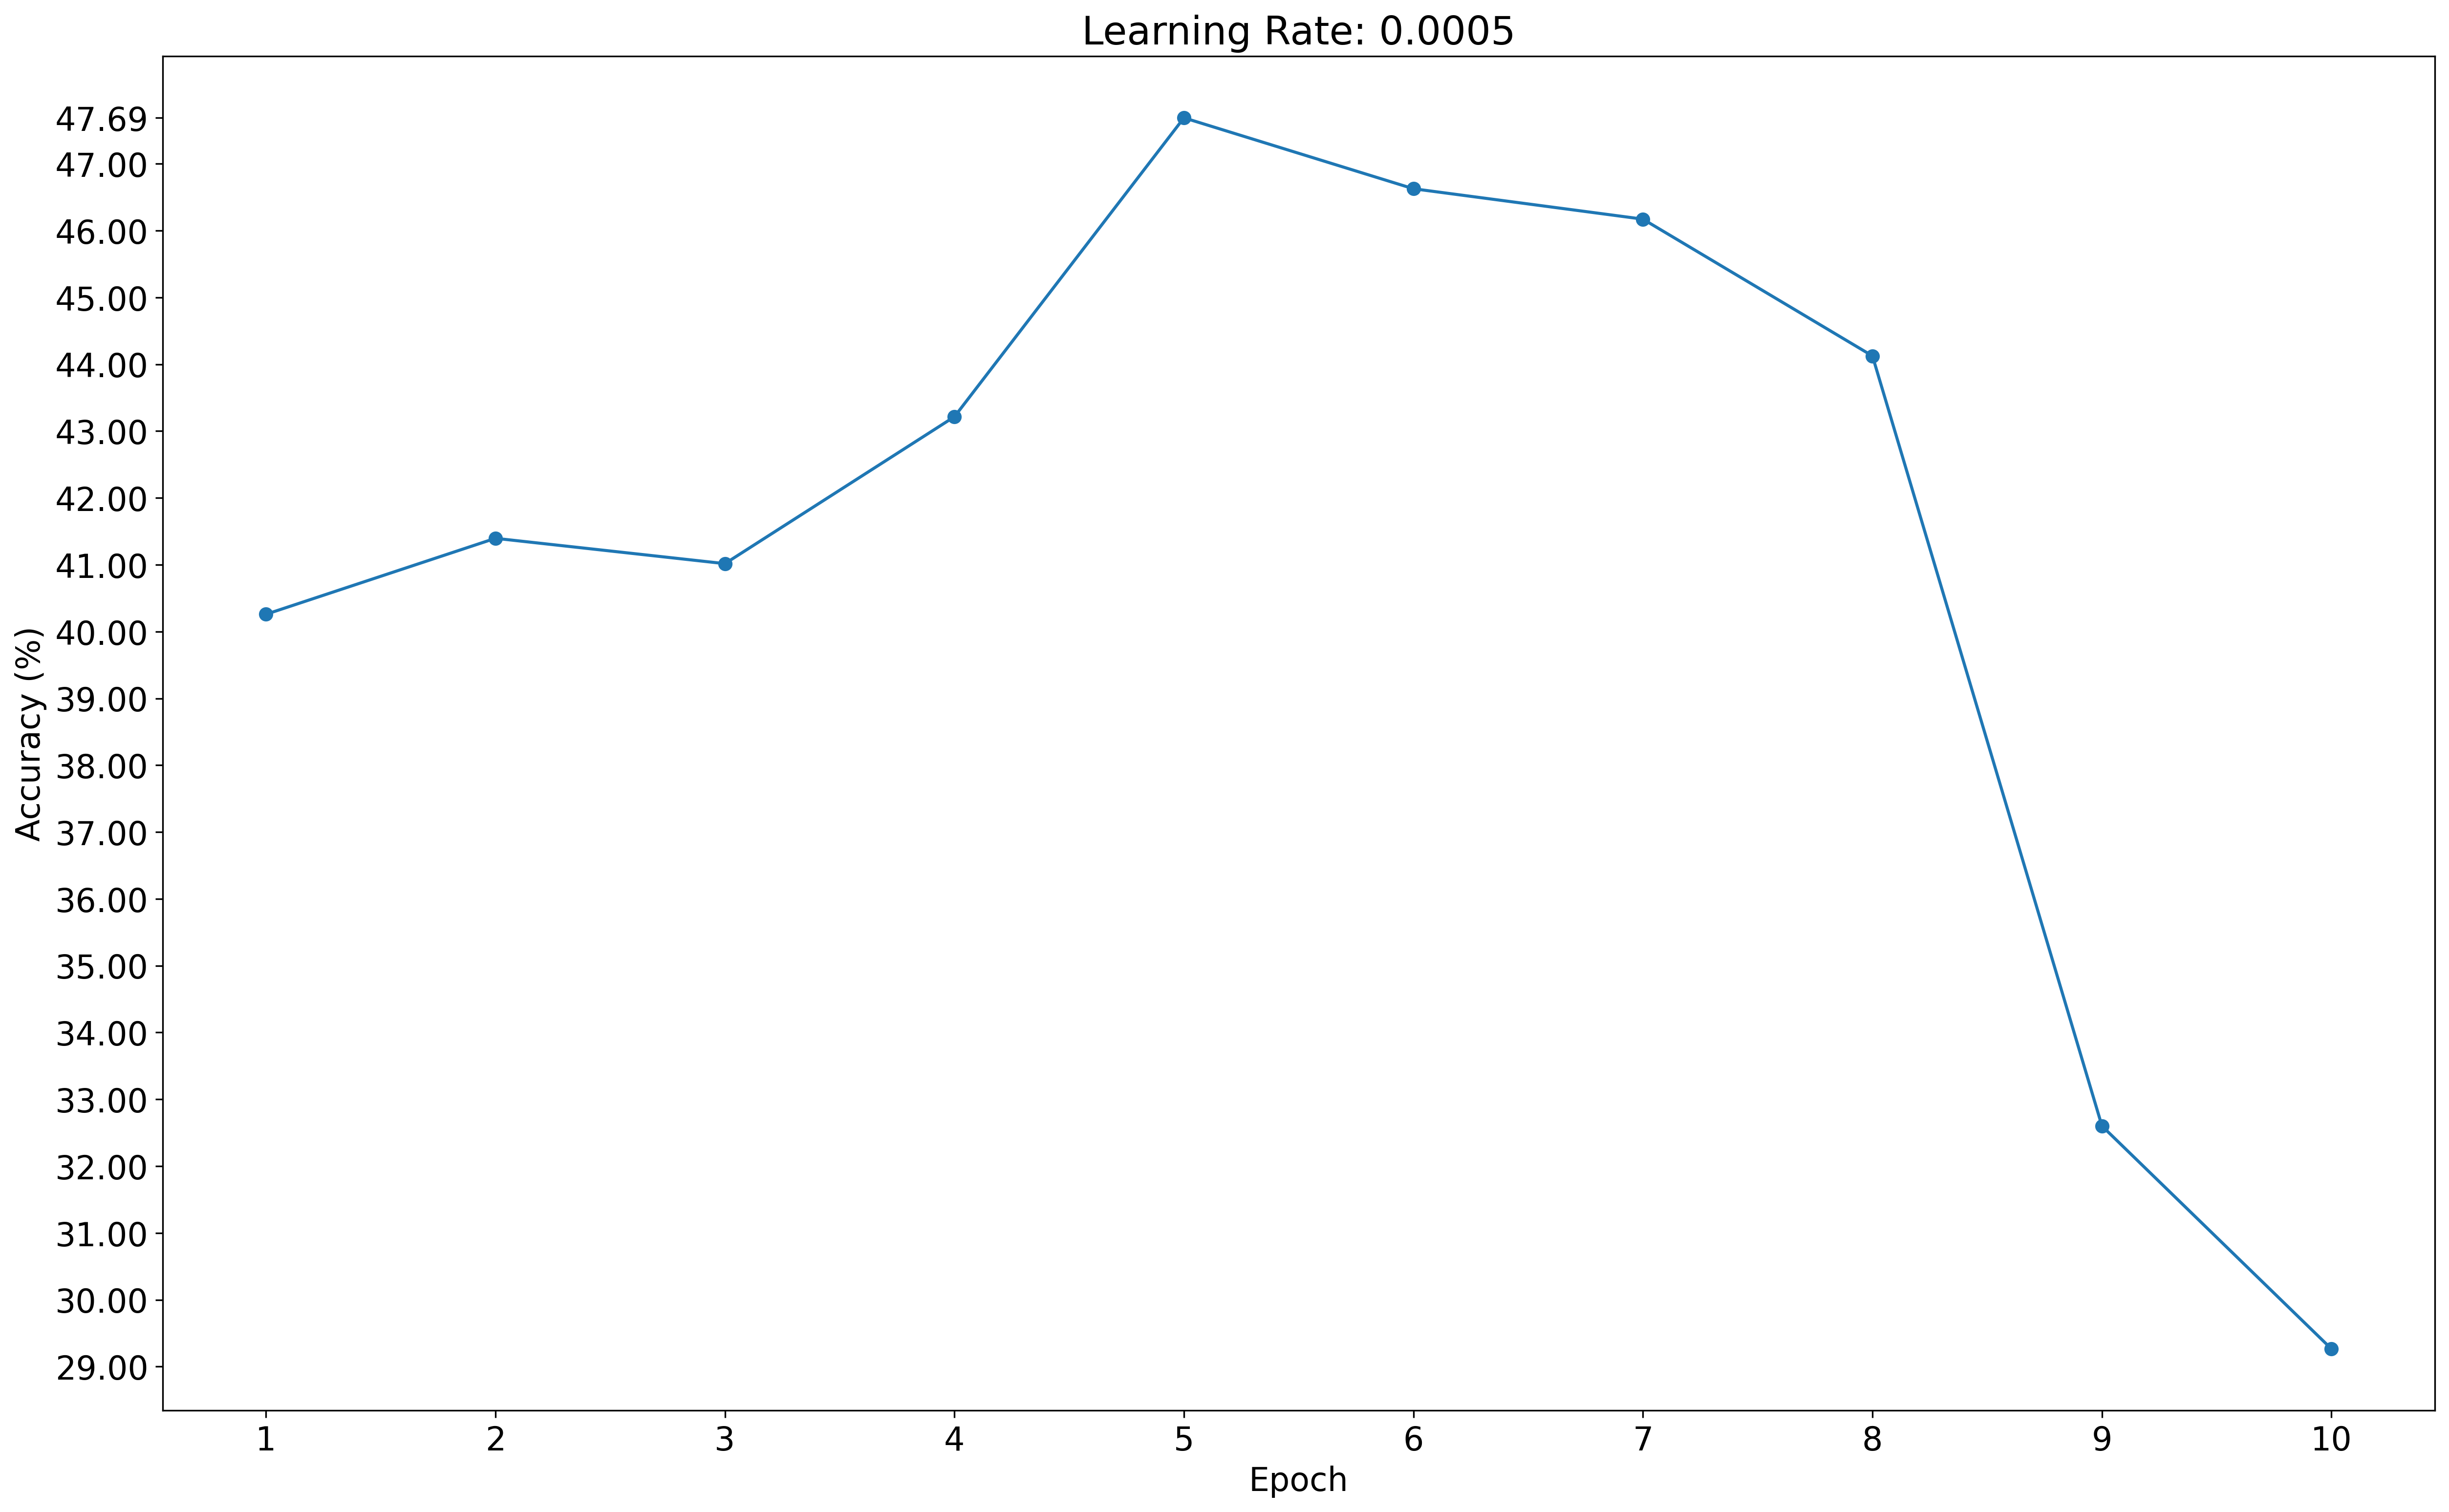

In [33]:
SHOW_PLOTS = True
if SHOW_PLOTS:
    for n_shot_to_run in filtered_runs_with_outputs:
        for n_shot, run in n_shot_to_run.items():
            by_epoch = {}
            learning_rates = set()
            for ckpt in run:
                results_path = ckpt.results_path
                epoch = int(ckpt.inference_outputs_path.name.split("_")[-1])
                # Extract results from this
                results_jsons = mit.one(results_path.glob("**/results*.json"))
                with open(results_jsons, "r") as f:
                    parsed = json.load(f)
                by_epoch[epoch] = parsed["results"]["all"]["qem"]
                learning_rate = ckpt.meta_config["training"]["learning_rate"]
                learning_rates.add(learning_rate)

            # Create a figure for each run
            plt.figure(figsize=(20, 12), dpi=300)
            plt.rcParams.update({'font.size': 16})
            plt.title(f"Learning Rate: {mit.one(learning_rates)}")

            by_epoch = dict(sorted(by_epoch.items()))
            y = np.array(list(by_epoch.values())) * 100
            x = np.array(list(by_epoch.keys())) + 1

            # Plot the accuracy for each epoch
            plt.plot(x, y, marker='o')
            plt.xticks(np.arange(1, x.max() + 1))
            plt.yticks(np.arange(int(y.min()), int(y.max()) + 1).tolist() + [y.max()])

            # Add labels and title
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy (%)")
            plt.show()
            


# We re-compute the the scores with our custom parser.

In [9]:
import verify
import importlib
importlib.reload(verify)

N_QTY = 100
MAX_NUM_EPOCHS = 15 

time_spent = verify.FractionTimeSpent()

output_data = collections.defaultdict(lambda: collections.defaultdict(list))
for i, n_shot_to_runs in enumerate(filtered_runs_with_outputs):
    for n_shot, runs in n_shot_to_runs.items():
        if n_shot == 0:
            for run in runs:
                parquet_path = mit.one(run.inference_outputs_path.glob("**/*.parquet"))
                results = verify.compute_score_for_rejection_sampling(
                    parquet_path, 
                    mode=verify.Mode.gsm8k, 
                    time_spent=time_spent, 
                    compute_score=True, 
                    subset_qty=N_QTY
                )
                output_data[i][n_shot].append(results)



i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_2
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_8
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_6
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_1
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_5
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_7
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_0
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_4
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_9
i: 0.0%
_home_mila_g_gagnonju_scratch_rejection_sampling_saves_gsm8k_5_2025-04-18_18-58-10_epoch_3


Epoch: 0, Learning Rate: 0.0005, Score: 0.43
Epoch: 1, Learning Rate: 0.0005, Score: 0.41
Epoch: 2, Learning Rate: 0.0005, Score: 0.4
Epoch: 3, Learning Rate: 0.0005, Score: 0.43
Epoch: 4, Learning Rate: 0.0005, Score: 0.47
Epoch: 5, Learning Rate: 0.0005, Score: 0.39
Epoch: 6, Learning Rate: 0.0005, Score: 0.47
Epoch: 7, Learning Rate: 0.0005, Score: 0.41
Epoch: 8, Learning Rate: 0.0005, Score: 0.32
Epoch: 9, Learning Rate: 0.0005, Score: 0.24


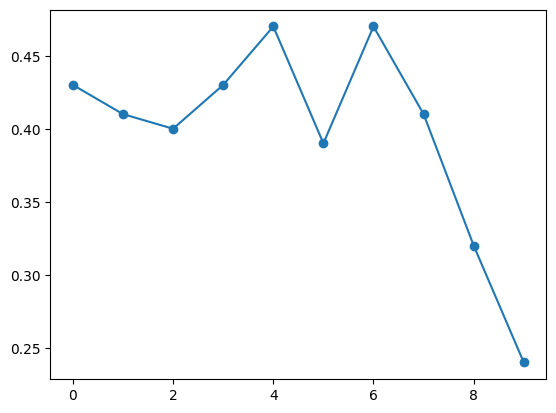

In [29]:
scores = []
for entry in sorted(output_data[0][0], key=lambda entry: mit.one(entry[0]["epoch"])):
    epoch = mit.one(entry[0]["epoch"])
    learning_rate = mit.one(entry[0]["learning_rate"])
    score = mit.one(entry[0]["score"])
    print(f"Epoch: {epoch}, Learning Rate: {learning_rate}, Score: {score}")
    scores.append(score)

plt.plot(scores, marker='o')